In [ ]:

# Import libraries
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os

# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

GPU available: True
GPU name: Tesla T4


In [ ]:
# In a code cell
%pip install -U "datasets" "huggingface_hub" "fsspec"


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
from datasets import load_dataset

print("Loading SST-2 dataset…")
dataset = load_dataset("glue", "sst2")

print(f"Train size: {len(dataset['train'])}")


Loading SST-2 dataset…


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Train size: 67349


In [ ]:
# Explore dataset structure
print("Dataset structure:")
print(f"Train size: {len(dataset['train'])}")
print(f"Validation size: {len(dataset['validation'])}")
print(f"Test size: {len(dataset['test'])}")
print(f"Features: {dataset['train'].features}")
print(f"Sample entry: {dataset['train'][0]}")

# Check class distributionB
train_labels = dataset['train']['label']
print(f"Class distribution - Negative: {train_labels.count(0)}, Positive: {train_labels.count(1)}")

# Note: SST-2 has train/validation/test splits
# Test set doesn't have labels (for competition), so we'll use validation as our test set
print(f"Note: Using validation set as test set since test set has no labels")

Dataset structure:
Train size: 67349
Validation size: 872
Test size: 1821
Features: {'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'idx': Value(dtype='int32', id=None)}
Sample entry: {'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}
Class distribution - Negative: 29780, Positive: 37569
Note: Using validation set as test set since test set has no labels


In [ ]:
# Data cleaning and preprocessing for SST-2
def clean_text(text):
    """Clean and preprocess text data"""
    import re
    # Remove extra whitespace
    text = ' '.join(text.split())
    # SST-2 is already quite clean, so minimal preprocessing needed
    # Remove very short sentences (less than 3 words)
    if len(text.split()) < 3:
        return None
    return text

# Apply cleaning to datasets
print("Cleaning datasets...")
train_clean = []
val_clean = []

for example in dataset['train']:
    cleaned = clean_text(example['sentence'])  # SST-2 uses 'sentence' field
    if cleaned:
        train_clean.append({'sentence': cleaned, 'label': example['label']})

for example in dataset['validation']:
    cleaned = clean_text(example['sentence'])
    if cleaned:
        val_clean.append({'sentence': cleaned, 'label': example['label']})

print(f"Original train size: {len(dataset['train'])}, After cleaning: {len(train_clean)}")
print(f"Original validation size: {len(dataset['validation'])}, After cleaning: {len(val_clean)}")

# Convert back to dataset format
from datasets import Dataset
train_dataset_full = Dataset.from_list(train_clean)
test_dataset = Dataset.from_list(val_clean)  # Using validation as test set

Cleaning datasets...
Original train size: 67349, After cleaning: 55838
Original validation size: 872, After cleaning: 870


In [ ]:
# Split training data into train/validation (without stratify for now)
train_val_split = train_dataset_full.train_test_split(test_size=0.15, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f"Final splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Verify class distribution in each split
def check_class_distribution(dataset, name):
    labels = dataset['label']
    neg_count = sum(1 for label in labels if label == 0)
    pos_count = sum(1 for label in labels if label == 1)
    total = len(labels)
    print(f"{name} - Negative: {neg_count} ({neg_count/total*100:.1f}%), Positive: {pos_count} ({pos_count/total*100:.1f}%)")

check_class_distribution(train_dataset, "Train")
check_class_distribution(val_dataset, "Validation")
check_class_distribution(test_dataset, "Test")

Final splits - Train: 47462, Val: 8376, Test: 870
Train - Negative: 21171 (44.6%), Positive: 26291 (55.4%)
Validation - Negative: 3739 (44.6%), Positive: 4637 (55.4%)
Test - Negative: 427 (49.1%), Positive: 443 (50.9%)


In [ ]:
# Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Tokenization function for SST-2
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],  # SST-2 uses 'sentence' field
        truncation=True,
        padding="max_length",
        max_length=128,  # SST-2 sentences are shorter than IMDb reviews
        return_tensors="pt"
    )

# Apply tokenization
print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("Dataset formatting completed!")
print(f"Sample tokenized input shape: {train_dataset[0]['input_ids'].shape}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/47462 [00:00<?, ? examples/s]

Map:   0%|          | 0/8376 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Dataset formatting completed!
Sample tokenized input shape: torch.Size([128])


In [ ]:
# Load pre-trained model
print("Loading base model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

# Comprehensive model selection justification
model_justification = """
Model Selection Justification:

1. TASK REQUIREMENTS:
   - Binary sentiment classification task
   - Need for efficient training with limited computational resources
   - Requirement for good performance on movie review text

2. MODEL CHOICE: DistilBERT-base-uncased
   - Architecture: Transformer-based, distilled from BERT
   - Parameters: 66M (vs BERT's 110M)
   - Performance: Retains 95% of BERT's performance
   - Speed: 40% smaller, 60% faster than BERT-base
   - Memory: Lower memory footprint suitable for Colab

3. DOMAIN SUITABILITY:
   - Pre-trained on general English text (good for SST-2 sentences)
   - Uncased version appropriate for varied sentence capitalization
   - Strong performance on GLUE sentiment tasks (SST-2 is part of GLUE)
   - Well-suited for sequence classification

4. ALTERNATIVES CONSIDERED:
   - BERT-base: Too large for quick iteration
   - RoBERTa: Higher performance but larger size
   - GPT-2: Better for generation, not classification
   - ALBERT: Good compression but slower inference

5. ARCHITECTURE SETUP:
   - Using AutoModelForSequenceClassification
   - Added classification head for binary sentiment
   - Configured label mappings for interpretability
"""
print(model_justification)

# Log model architecture details
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loading base model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Selection Justification:

1. TASK REQUIREMENTS:
   - Binary sentiment classification task
   - Need for efficient training with limited computational resources
   - Requirement for good performance on movie review text

2. MODEL CHOICE: DistilBERT-base-uncased
   - Architecture: Transformer-based, distilled from BERT
   - Parameters: 66M (vs BERT's 110M)
   - Performance: Retains 95% of BERT's performance
   - Speed: 40% smaller, 60% faster than BERT-base
   - Memory: Lower memory footprint suitable for Colab

3. DOMAIN SUITABILITY:
   - Pre-trained on general English text (good for SST-2 sentences)
   - Uncased version appropriate for varied sentence capitalization
   - Strong performance on GLUE sentiment tasks (SST-2 is part of GLUE)
   - Well-suited for sequence classification

4. ALTERNATIVES CONSIDERED:
   - BERT-base: Too large for quick iteration
   - RoBERTa: Higher performance but larger size
   - GPT-2: Better for generation, not classification
   - ALBERT: Good compr

In [ ]:
# Configure LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,                    # Low rank
    lora_alpha=32,          # LoRA scaling parameter
    lora_dropout=0.1,       # Dropout for LoRA layers
    target_modules=["q_lin", "v_lin"]  # Target attention layers
)

# Apply LoRA to model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


In [ ]:
# Configure training environment
print("Configuring training environment...")

# Set up device and memory optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

    # Enable mixed precision training for efficiency
    torch.backends.cudnn.benchmark = True

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Create directories for outputs
import os
os.makedirs('./results', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./logs', exist_ok=True)

print("Training environment configured successfully!")

Configuring training environment...
Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
Training environment configured successfully!


In [ ]:
# Well-defined hyperparameter search strategy
hyperparameter_strategy = """
HYPERPARAMETER OPTIMIZATION STRATEGY:

1. SEARCH SPACE DEFINITION:
   - Learning Rate: [2e-5, 3e-5, 5e-5] (common range for BERT-based models)
   - Epochs: [2, 3, 4] (balanced between overfitting and underfitting)
   - Batch Size: 16 (fixed due to memory constraints)
   - Weight Decay: 0.01 (fixed, standard value)
   - Warmup Steps: 100 (fixed, 10% of total steps)

2. SEARCH METHOD:
   - Grid search over learning rate and epochs
   - Total configurations: 3 LR × 3 epochs = 9 combinations
   - Reduced to 3 best combinations for time efficiency

3. EVALUATION CRITERIA:
   - Primary: F1 score on validation set
   - Secondary: Validation accuracy
   - Tertiary: Training stability (loss convergence)

4. SELECTED CONFIGURATIONS:
   - Config 1: LR=2e-5, Epochs=3 (conservative)
   - Config 2: LR=3e-5, Epochs=3 (balanced)
   - Config 3: LR=5e-5, Epochs=2 (aggressive)
"""
print(hyperparameter_strategy)

# Define hyperparameter configurations to test
hyperparameter_configs = [
    {
        "learning_rate": 2e-5,
        "num_train_epochs": 3,
        "per_device_train_batch_size": 16,
        "name": "config_1_conservative",
        "description": "Conservative learning rate, standard epochs"
    },
    {
        "learning_rate": 3e-5,
        "num_train_epochs": 3,
        "per_device_train_batch_size": 16,
        "name": "config_2_balanced",
        "description": "Balanced learning rate, standard epochs"
    },
    {
        "learning_rate": 5e-5,
        "num_train_epochs": 2,
        "per_device_train_batch_size": 16,
        "name": "config_3_aggressive",
        "description": "Higher learning rate, fewer epochs"
    }
]

# Storage for detailed results
training_results = []
detailed_logs = []


HYPERPARAMETER OPTIMIZATION STRATEGY:

1. SEARCH SPACE DEFINITION:
   - Learning Rate: [2e-5, 3e-5, 5e-5] (common range for BERT-based models)
   - Epochs: [2, 3, 4] (balanced between overfitting and underfitting)
   - Batch Size: 16 (fixed due to memory constraints)
   - Weight Decay: 0.01 (fixed, standard value)
   - Warmup Steps: 100 (fixed, 10% of total steps)

2. SEARCH METHOD:
   - Grid search over learning rate and epochs
   - Total configurations: 3 LR × 3 epochs = 9 combinations
   - Reduced to 3 best combinations for time efficiency

3. EVALUATION CRITERIA:
   - Primary: F1 score on validation set
   - Secondary: Validation accuracy
   - Tertiary: Training stability (loss convergence)

4. SELECTED CONFIGURATIONS:
   - Config 1: LR=2e-5, Epochs=3 (conservative)
   - Config 2: LR=3e-5, Epochs=3 (balanced)
   - Config 3: LR=5e-5, Epochs=2 (aggressive)



In [ ]:
# Disable HuggingFace Hub requirements
import os
import warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_OFFLINE"] = "1"
warnings.filterwarnings("ignore")

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Ultra-compatible training function
def train_model_simple(config):
    print(f"\n{'='*50}")
    print(f"Training with {config['name']}")
    print(f"{'='*50}")
    print(f"Learning rate: {config['learning_rate']}")
    print(f"Epochs: {config['num_train_epochs']}")
    print(f"Batch size: {config['per_device_train_batch_size']}")

    # Most basic training arguments (guaranteed to work)
    training_args = TrainingArguments(
        output_dir=f"./results/{config['name']}",
        num_train_epochs=config['num_train_epochs'],
        per_device_train_batch_size=config['per_device_train_batch_size'],
        per_device_eval_batch_size=16,
        learning_rate=config['learning_rate'],
        weight_decay=0.01,
        logging_steps=50,
        save_steps=500,
        eval_steps=500,
        save_total_limit=2,
        seed=42,
        report_to=None,  # This prevents wandb/tensorboard logging
        hub_model_id=None,  # This prevents hub upload attempts
        push_to_hub=False   # This prevents hub upload attempts
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Train
    print("Starting training...")
    start_time = datetime.now()
    trainer.train()
    training_time = datetime.now() - start_time

    # Manual evaluation
    print("Evaluating...")
    eval_results = trainer.evaluate()

    # Save model locally (no hub upload)
    model_path = f"./models/{config['name']}"
    os.makedirs(model_path, exist_ok=True)
    trainer.save_model(model_path)

    results = {
        "config": config,
        "training_time": str(training_time),
        "eval_results": eval_results,
        "model_path": model_path,
        "final_metrics": {
            "accuracy": eval_results.get('eval_accuracy', 0),
            "f1": eval_results.get('eval_f1', 0),
            "loss": eval_results.get('eval_loss', 0)
        }
    }

    return trainer, results

# Train all configurations
print("Starting hyperparameter optimization...")
for i, config in enumerate(hyperparameter_configs):
    print(f"\nConfiguration {i+1}/{len(hyperparameter_configs)}")
    trainer, results = train_model_simple(config)

    training_results.append(results)

    print(f"\nResults for {config['name']}:")
    print(f"  Accuracy: {results['final_metrics']['accuracy']:.4f}")
    print(f"  F1 Score: {results['final_metrics']['f1']:.4f}")
    print(f"  Training time: {results['training_time']}")
    print(f"  Model saved at: {results['model_path']}")

print(f"\nHyperparameter optimization completed!")
print(f"Successfully trained {len(training_results)}/{len(hyperparameter_configs)} configurations")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting hyperparameter optimization...

Configuration 1/3

Training with config_1_conservative
Learning rate: 2e-05
Epochs: 3
Batch size: 16
Starting training...


Step,Training Loss
50,0.685400
100,0.666500
150,0.618400
200,0.522800
250,0.426100
300,0.389200
350,0.370400
400,0.360700
450,0.335300
500,0.354300


Evaluating...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Results for config_1_conservative:
  Accuracy: 0.8926
  F1 Score: 0.9018
  Training time: 0:18:08.295770
  Model saved at: ./models/config_1_conservative

Configuration 2/3

Training with config_2_balanced
Learning rate: 3e-05
Epochs: 3
Batch size: 16
Starting training...


Step,Training Loss
50,0.280600
100,0.275000
150,0.289300
200,0.329700
250,0.294100
300,0.273900
350,0.291200
400,0.251800
450,0.261300
500,0.264000


Evaluating...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Results for config_2_balanced:
  Accuracy: 0.9060
  F1 Score: 0.9144
  Training time: 0:18:05.469888
  Model saved at: ./models/config_2_balanced

Configuration 3/3

Training with config_3_aggressive
Learning rate: 5e-05
Epochs: 2
Batch size: 16
Starting training...


Step,Training Loss
50,0.230200
100,0.236900
150,0.242600
200,0.287300
250,0.249800
300,0.223800
350,0.261700
400,0.221500
450,0.248000
500,0.230600


Evaluating...



Results for config_3_aggressive:
  Accuracy: 0.9126
  F1 Score: 0.9202
  Training time: 0:12:00.763983
  Model saved at: ./models/config_3_aggressive

Hyperparameter optimization completed!
Successfully trained 3/3 configurations


In [ ]:
# Comprehensive evaluation metrics implementation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, classification_report

def comprehensive_evaluation(model, dataset, tokenizer, dataset_name="Test"):
    """
    Comprehensive evaluation with multiple metrics appropriate for sentiment analysis
    """
    print(f"\n{'='*50}")
    print(f"COMPREHENSIVE EVALUATION - {dataset_name.upper()} SET")
    print(f"{'='*50}")

    # Initialize trainer for prediction
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Get predictions
    predictions = trainer.predict(dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids
    pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)

    # 1. ACCURACY METRICS
    accuracy = accuracy_score(true_labels, pred_labels)

    # 2. PRECISION, RECALL, F1 (both macro and weighted)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted'
    )

    # 3. PER-CLASS METRICS
    precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(
        true_labels, pred_labels, average=None
    )

    # 4. AUC-ROC (appropriate for binary classification)
    auc_roc = roc_auc_score(true_labels, pred_probs[:, 1])

    # 5. CONFUSION MATRIX
    cm = confusion_matrix(true_labels, pred_labels)

    # Compile results
    evaluation_results = {
        "dataset_name": dataset_name,
        "sample_size": len(true_labels),
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "auc_roc": auc_roc,
        "per_class_metrics": {
            "negative": {
                "precision": precision_class[0],
                "recall": recall_class[0],
                "f1": f1_class[0],
                "support": support_class[0]
            },
            "positive": {
                "precision": precision_class[1],
                "recall": recall_class[1],
                "f1": f1_class[1],
                "support": support_class[1]
            }
        },
        "confusion_matrix": cm.tolist(),
        "predictions": pred_labels.tolist(),
        "true_labels": true_labels.tolist(),
        "prediction_probabilities": pred_probs.numpy().tolist()
    }

    # Print results
    print(f"Dataset: {dataset_name}")
    print(f"Sample Size: {len(true_labels)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"\nPer-Class Metrics:")
    print(f"  Negative - Precision: {precision_class[0]:.4f}, Recall: {recall_class[0]:.4f}, F1: {f1_class[0]:.4f}")
    print(f"  Positive - Precision: {precision_class[1]:.4f}, Recall: {recall_class[1]:.4f}, F1: {f1_class[1]:.4f}")

    return evaluation_results, predictions

# Select best model based on validation performance
best_config = max(training_results, key=lambda x: x['final_metrics']['f1'])
print(f"\nBest configuration selected: {best_config['config']['name']}")
print(f"Best validation F1 score: {best_config['final_metrics']['f1']:.4f}")

# Load best model
best_model_path = best_config['model_path']
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)

# Comprehensive evaluation on test set
test_results, test_predictions = comprehensive_evaluation(best_model, test_dataset, tokenizer, "Test")


Best configuration selected: config_3_aggressive
Best validation F1 score: 0.9202


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



COMPREHENSIVE EVALUATION - TEST SET


Dataset: Test
Sample Size: 870
Accuracy: 0.8851
F1 Score (Macro): 0.8850
F1 Score (Weighted): 0.8850
Precision (Macro): 0.8852
Recall (Macro): 0.8848
AUC-ROC: 0.9578

Per-Class Metrics:
  Negative - Precision: 0.8902, Recall: 0.8735, F1: 0.8818
  Positive - Precision: 0.8803, Recall: 0.8962, F1: 0.8881


In [ ]:
# Baseline model evaluation (pre-trained model without fine-tuning)
print(f"\n{'='*50}")
print("BASELINE MODEL EVALUATION")
print(f"{'='*50}")

# Load baseline model (same architecture, no fine-tuning)
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

# Evaluate baseline on test set
baseline_results, baseline_predictions = comprehensive_evaluation(
    baseline_model, test_dataset, tokenizer, "Baseline"
)

# Detailed comparison analysis
print(f"\n{'='*60}")
print("DETAILED BASELINE vs FINE-TUNED COMPARISON")
print(f"{'='*60}")

comparison_metrics = [
    ("Accuracy", "accuracy"),
    ("F1 Score (Macro)", "f1_macro"),
    ("F1 Score (Weighted)", "f1_weighted"),
    ("Precision (Macro)", "precision_macro"),
    ("Recall (Macro)", "recall_macro"),
    ("AUC-ROC", "auc_roc")
]

comparison_results = {}
for metric_name, metric_key in comparison_metrics:
    baseline_value = baseline_results[metric_key]
    finetuned_value = test_results[metric_key]
    improvement = finetuned_value - baseline_value
    improvement_percent = (improvement / baseline_value) * 100 if baseline_value > 0 else 0

    comparison_results[metric_key] = {
        "baseline": baseline_value,
        "finetuned": finetuned_value,
        "improvement": improvement,
        "improvement_percent": improvement_percent
    }

    print(f"{metric_name}:")
    print(f"  Baseline: {baseline_value:.4f}")
    print(f"  Fine-tuned: {finetuned_value:.4f}")
    print(f"  Improvement: +{improvement:.4f} ({improvement_percent:+.1f}%)")
    print()

# Statistical significance test (if applicable)
from scipy import stats
if len(test_results['predictions']) > 30:  # Basic check for sufficient sample size
    # McNemar's test for comparing two models
    baseline_correct = np.array(baseline_results['predictions']) == np.array(baseline_results['true_labels'])
    finetuned_correct = np.array(test_results['predictions']) == np.array(test_results['true_labels'])

    # Create contingency table
    both_correct = np.sum(baseline_correct & finetuned_correct)
    baseline_only = np.sum(baseline_correct & ~finetuned_correct)
    finetuned_only = np.sum(~baseline_correct & finetuned_correct)
    both_wrong = np.sum(~baseline_correct & ~finetuned_correct)

    print("Statistical Significance Analysis:")
    print(f"  Both correct: {both_correct}")
    print(f"  Baseline only correct: {baseline_only}")
    print(f"  Fine-tuned only correct: {finetuned_only}")
    print(f"  Both incorrect: {both_wrong}")

    if baseline_only + finetuned_only > 0:
        mcnemar_stat = (abs(baseline_only - finetuned_only) - 1)**2 / (baseline_only + finetuned_only)
        p_value = 1 - stats.chi2.cdf(mcnemar_stat, 1)
        print(f"  McNemar's test p-value: {p_value:.4f}")
        print(f"  Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")


BASELINE MODEL EVALUATION


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



COMPREHENSIVE EVALUATION - BASELINE SET


Dataset: Baseline
Sample Size: 870
Accuracy: 0.4747
F1 Score (Macro): 0.4531
F1 Score (Weighted): 0.4551
Precision (Macro): 0.4664
Recall (Macro): 0.4712
AUC-ROC: 0.4359

Per-Class Metrics:
  Negative - Precision: 0.4444, Recall: 0.2810, F1: 0.3443
  Positive - Precision: 0.4883, Recall: 0.6614, F1: 0.5618

DETAILED BASELINE vs FINE-TUNED COMPARISON
Accuracy:
  Baseline: 0.4747
  Fine-tuned: 0.8851
  Improvement: +0.4103 (+86.4%)

F1 Score (Macro):
  Baseline: 0.4531
  Fine-tuned: 0.8850
  Improvement: +0.4319 (+95.3%)

F1 Score (Weighted):
  Baseline: 0.4551
  Fine-tuned: 0.8850
  Improvement: +0.4299 (+94.5%)

Precision (Macro):
  Baseline: 0.4664
  Fine-tuned: 0.8852
  Improvement: +0.4189 (+89.8%)

Recall (Macro):
  Baseline: 0.4712
  Fine-tuned: 0.8848
  Improvement: +0.4136 (+87.8%)

AUC-ROC:
  Baseline: 0.4359
  Fine-tuned: 0.9578
  Improvement: +0.5219 (+119.7%)

Statistical Significance Analysis:
  Both correct: 356
  Baseline only correct: 57
  Fine-tuned only correct: 414
  

In [ ]:
# Comprehensive error analysis
print(f"\n{'='*60}")
print("COMPREHENSIVE ERROR ANALYSIS")
print(f"{'='*60}")

# Get predictions and true labels
pred_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids
pred_probs = torch.softmax(torch.tensor(test_predictions.predictions), dim=1)

# Find incorrect predictions
incorrect_indices = np.where(pred_labels != true_labels)[0]
print(f"Total errors: {len(incorrect_indices)} out of {len(true_labels)} ({len(incorrect_indices)/len(true_labels)*100:.1f}%)")

# Analyze error types
false_positives = np.where((pred_labels == 1) & (true_labels == 0))[0]
false_negatives = np.where((pred_labels == 0) & (true_labels == 1))[0]

print(f"False Positives: {len(false_positives)} ({len(false_positives)/len(true_labels)*100:.1f}%)")
print(f"False Negatives: {len(false_negatives)} ({len(false_negatives)/len(true_labels)*100:.1f}%)")

# Let's check what fields are available in the dataset
print("Available fields in test dataset:", test_dataset.features.keys())
print("Sample item keys:", list(test_dataset[0].keys()))

def analyze_error_examples(dataset, error_indices, error_type, n_examples=15):
    """Analyze specific error examples with detailed information"""
    print(f"\n--- {error_type.upper()} EXAMPLES ---")

    error_analysis = []
    for i, idx in enumerate(error_indices[:n_examples]):
        example = dataset[int(idx)]

        # Get prediction confidence
        confidence = float(pred_probs[idx].max())
        prob_negative = float(pred_probs[idx][0])
        prob_positive = float(pred_probs[idx][1])

        # Try different field names
        text_content = ""
        if 'sentence' in example:
            text_content = example['sentence']
        elif 'text' in example:
            text_content = example['text']
        else:
            # If no text field, decode from input_ids
            text_content = tokenizer.decode(example['input_ids'], skip_special_tokens=True)

        error_case = {
            "index": int(idx),
            "text": text_content,
            "text_length": len(text_content),
            "word_count": len(text_content.split()),
            "true_label": "POSITIVE" if true_labels[idx] == 1 else "NEGATIVE",
            "predicted_label": "POSITIVE" if pred_labels[idx] == 1 else "NEGATIVE",
            "confidence": confidence,
            "prob_negative": prob_negative,
            "prob_positive": prob_positive,
            "error_type": error_type
        }
        error_analysis.append(error_case)

        # Print detailed example
        print(f"\nExample {i+1}:")
        print(f"  Index: {idx}")
        print(f"  Text: {text_content[:150]}{'...' if len(text_content) > 150 else ''}")
        print(f"  True Label: {error_case['true_label']}")
        print(f"  Predicted: {error_case['predicted_label']}")
        print(f"  Confidence: {confidence:.3f}")
        print(f"  Prob(Negative): {prob_negative:.3f}, Prob(Positive): {prob_positive:.3f}")
        print(f"  Length: {error_case['text_length']} chars, {error_case['word_count']} words")

    return error_analysis

# Analyze false positives and false negatives
fp_analysis = analyze_error_examples(test_dataset, false_positives, "False Positives", 10)
fn_analysis = analyze_error_examples(test_dataset, false_negatives, "False Negatives", 10)

all_error_analysis = fp_analysis + fn_analysis


COMPREHENSIVE ERROR ANALYSIS
Total errors: 100 out of 870 (11.5%)
False Positives: 54 (6.2%)
False Negatives: 46 (5.3%)
Available fields in test dataset: dict_keys(['sentence', 'label', 'input_ids', 'attention_mask'])
Sample item keys: ['label', 'input_ids', 'attention_mask']

--- FALSE POSITIVES EXAMPLES ---

Example 1:
  Index: 22
  Text: holden caulfield did it better.
  True Label: NEGATIVE
  Predicted: POSITIVE
  Confidence: 0.828
  Prob(Negative): 0.172, Prob(Positive): 0.828
  Length: 31 chars, 5 words

Example 2:
  Index: 33
  Text: if the movie succeeds in instilling a wary sense of ` there but for the grace of god, ' it is far too self - conscious to draw you deeply into its wor...
  True Label: NEGATIVE
  Predicted: POSITIVE
  Confidence: 0.967
  Prob(Negative): 0.033, Prob(Positive): 0.967
  Length: 153 chars, 33 words

Example 3:
  Index: 69
  Text: this one is definitely one to skip, even for horror movie fanatics.
  True Label: NEGATIVE
  Predicted: POSITIVE
  Confidenc

In [ ]:
# Pattern identification in errors
print(f"\n{'='*60}")
print("ERROR PATTERN IDENTIFICATION")
print(f"{'='*60}")

def identify_error_patterns(error_cases):
    """Identify common patterns in model errors"""
    patterns = {
        "subtle_negative_words": {
            "cases": [],
            "keywords": ["skip", "fails", "wo n't", "can't", "doesn't", "never", "without"],
            "description": "Subtle negative indicators the model missed"
        },
        "mixed_sentiment": {
            "cases": [],
            "keywords": ["but", "however", "although", "despite", "though", "even", "while"],
            "description": "Reviews with mixed positive and negative elements"
        },
        "contextual_positives": {
            "cases": [],
            "keywords": ["impressive", "kudos", "privileged", "best", "success", "glorious"],
            "description": "Positive words in negative contexts"
        },
        "sarcasm_irony": {
            "cases": [],
            "keywords": ["hilariously inept", "ridiculous", "better message", "definitely one to skip"],
            "description": "Sarcastic or ironic statements"
        },
        "short_sentences": {
            "cases": [],
            "keywords": [],
            "description": "Very short sentences with subtle sentiment"
        },
        "complex_structures": {
            "cases": [],
            "keywords": [],
            "description": "Long, complex sentences requiring deep understanding"
        },
        "high_confidence_errors": {
            "cases": [],
            "keywords": [],
            "description": "High-confidence incorrect predictions"
        }
    }

    for case in error_cases:
        text_lower = case["text"].lower()

        # Check for subtle negative words
        if any(keyword in text_lower for keyword in patterns["subtle_negative_words"]["keywords"]):
            patterns["subtle_negative_words"]["cases"].append(case)

        # Check for mixed sentiment
        elif any(keyword in text_lower for keyword in patterns["mixed_sentiment"]["keywords"]):
            patterns["mixed_sentiment"]["cases"].append(case)

        # Check for contextual positives
        elif any(keyword in text_lower for keyword in patterns["contextual_positives"]["keywords"]):
            patterns["contextual_positives"]["cases"].append(case)

        # Check for sarcasm/irony
        elif any(keyword in text_lower for keyword in patterns["sarcasm_irony"]["keywords"]):
            patterns["sarcasm_irony"]["cases"].append(case)

        # Check for short sentences
        elif case["word_count"] <= 8:
            patterns["short_sentences"]["cases"].append(case)

        # Check for complex structures
        elif case["word_count"] > 25:
            patterns["complex_structures"]["cases"].append(case)

        # Check for high confidence errors
        if case["confidence"] > 0.9:
            patterns["high_confidence_errors"]["cases"].append(case)

    return patterns

error_patterns = identify_error_patterns(all_error_analysis)

print("Error Pattern Analysis:")
total_analyzed = len(all_error_analysis)
for pattern_name, pattern_info in error_patterns.items():
    count = len(pattern_info["cases"])
    percentage = (count / total_analyzed * 100) if total_analyzed > 0 else 0
    print(f"\n{pattern_name.upper().replace('_', ' ')}:")
    print(f"  Count: {count} ({percentage:.1f}% of analyzed errors)")
    print(f"  Description: {pattern_info['description']}")

    # Show example if available
    if pattern_info["cases"]:
        example = pattern_info["cases"][0]
        print(f"  Example: {example['text'][:80]}...")
        print(f"  True: {example['true_label']}, Predicted: {example['predicted_label']}")

# Confidence analysis
print(f"\n{'='*40}")
print("CONFIDENCE ANALYSIS")
print(f"{'='*40}")

# Analyze confidence distribution for correct vs incorrect predictions
correct_indices = np.where(pred_labels == true_labels)[0]
correct_confidences = [float(pred_probs[i].max()) for i in correct_indices]
incorrect_confidences = [float(pred_probs[i].max()) for i in incorrect_indices]

print(f"Correct predictions - Mean confidence: {np.mean(correct_confidences):.3f}")
print(f"Incorrect predictions - Mean confidence: {np.mean(incorrect_confidences):.3f}")

# High-confidence errors (most concerning)
high_conf_errors = [i for i in incorrect_indices if pred_probs[i].max() > 0.9]
print(f"High-confidence errors (>0.9): {len(high_conf_errors)} ({len(high_conf_errors)/len(incorrect_indices)*100:.1f}% of errors)")


ERROR PATTERN IDENTIFICATION
Error Pattern Analysis:

SUBTLE NEGATIVE WORDS:
  Count: 3 (15.0% of analyzed errors)
  Description: Subtle negative indicators the model missed
  Example: this one is definitely one to skip, even for horror movie fanatics....
  True: NEGATIVE, Predicted: POSITIVE

MIXED SENTIMENT:
  Count: 7 (35.0% of analyzed errors)
  Description: Reviews with mixed positive and negative elements
  Example: if the movie succeeds in instilling a wary sense of ` there but for the grace of...
  True: NEGATIVE, Predicted: POSITIVE

CONTEXTUAL POSITIVES:
  Count: 2 (10.0% of analyzed errors)
  Description: Positive words in negative contexts
  Example: jaglom... put ( s ) the audience in the privileged position of eavesdropping on ...
  True: POSITIVE, Predicted: NEGATIVE

SARCASM IRONY:
  Count: 2 (10.0% of analyzed errors)
  Description: Sarcastic or ironic statements
  Example: hilariously inept and ridiculous....
  True: POSITIVE, Predicted: NEGATIVE

SHORT SENTENCES:
  

In [ ]:
# Generate specific improvement suggestions based on error analysis
print(f"\n{'='*60}")
print("SUGGESTED IMPROVEMENTS")
print(f"{'='*60}")

improvement_suggestions = []

# Analyze patterns and generate suggestions
for pattern_name, pattern_info in error_patterns.items():
    count = len(pattern_info["cases"])
    if count > 0:
        if pattern_name == "sarcasm_irony":
            suggestion = {
                "issue": "Sarcasm and irony detection",
                "frequency": count,
                "suggestions": [
                    "Augment training data with sarcasm-labeled examples",
                    "Implement attention mechanism analysis to identify sarcasm markers",
                    "Add contextual features for irony detection",
                    "Use specialized sarcasm detection models as preprocessing"
                ]
            }
        elif pattern_name == "mixed_sentiment":
            suggestion = {
                "issue": "Mixed sentiment handling",
                "frequency": count,
                "suggestions": [
                    "Implement aspect-based sentiment analysis",
                    "Add sentence-level sentiment aggregation",
                    "Train with more nuanced sentiment labels",
                    "Use attention weights to identify conflicting sentiments"
                ]
            }
        elif pattern_name == "negation_errors":
            suggestion = {
                "issue": "Negation handling",
                "frequency": count,
                "suggestions": [
                    "Implement negation-aware preprocessing",
                    "Add negation scope detection",
                    "Use dependency parsing to identify negation patterns",
                    "Augment training with negation-flipped examples"
                ]
            }
        elif pattern_name == "context_dependent":
            suggestion = {
                "issue": "Long context understanding",
                "frequency": count,
                "suggestions": [
                    "Implement hierarchical attention mechanisms",
                    "Use sliding window approach for long texts",
                    "Add document-level context modeling",
                    "Implement sentence-level importance weighting"
                ]
            }
        elif pattern_name == "high_confidence_errors":
            suggestion = {
                "issue": "Overconfident predictions",
                "frequency": count,
                "suggestions": [
                    "Implement confidence calibration techniques",
                    "Add uncertainty estimation methods",
                    "Use temperature scaling for probability calibration",
                    "Implement ensemble methods for better confidence estimates"
                ]
            }
        else:
            suggestion = {
                "issue": pattern_info["description"],
                "frequency": count,
                "suggestions": [
                    "Collect more training data for this pattern",
                    "Implement targeted data augmentation",
                    "Add specialized preprocessing for this case"
                ]
            }

        improvement_suggestions.append(suggestion)

# Print improvement suggestions
for i, suggestion in enumerate(improvement_suggestions, 1):
    print(f"\n{i}. {suggestion['issue'].upper()}")
    print(f"   Frequency: {suggestion['frequency']} cases")
    print(f"   Suggestions:")
    for j, sugg in enumerate(suggestion['suggestions'], 1):
        print(f"     {j}. {sugg}")

# Overall model improvement recommendations
print(f"\n{'='*60}")
print("OVERALL MODEL IMPROVEMENT RECOMMENDATIONS")
print(f"{'='*60}")

overall_recommendations = [
    "1. DATA AUGMENTATION:",
    "   - Add back-translation for data diversity",
    "   - Implement paraphrasing for robust training",
    "   - Collect domain-specific difficult examples",
    "",
    "2. ARCHITECTURE IMPROVEMENTS:",
    "   - Experiment with RoBERTa or ELECTRA for better understanding",
    "   - Add attention visualization for interpretability",
    "   - Implement multi-task learning with related tasks",
    "",
    "3. TRAINING ENHANCEMENTS:",
    "   - Use focal loss for hard example mining",
    "   - Implement curriculum learning",
    "   - Add adversarial training for robustness",
    "",
    "4. POST-PROCESSING:",
    "   - Implement ensemble methods",
    "   - Add confidence-based filtering",
    "   - Use rule-based post-processing for known patterns"
]

for rec in overall_recommendations:
    print(rec)

# Save error analysis results
error_analysis_summary = {
    "total_errors": len(incorrect_indices),
    "error_rate": len(incorrect_indices) / len(true_labels),
    "false_positives": len(false_positives),
    "false_negatives": len(false_negatives),
    "error_patterns": {name: len(info["cases"]) for name, info in error_patterns.items()},
    "high_confidence_errors": len(high_conf_errors),
    "improvement_suggestions": improvement_suggestions,
    "detailed_examples": all_error_analysis[:20]  # Save first 20 examples
}

print(f"\nError analysis completed. Summary saved.")


SUGGESTED IMPROVEMENTS

1. SUBTLE NEGATIVE INDICATORS THE MODEL MISSED
   Frequency: 3 cases
   Suggestions:
     1. Collect more training data for this pattern
     2. Implement targeted data augmentation
     3. Add specialized preprocessing for this case

2. MIXED SENTIMENT HANDLING
   Frequency: 7 cases
   Suggestions:
     1. Implement aspect-based sentiment analysis
     2. Add sentence-level sentiment aggregation
     3. Train with more nuanced sentiment labels
     4. Use attention weights to identify conflicting sentiments

3. POSITIVE WORDS IN NEGATIVE CONTEXTS
   Frequency: 2 cases
   Suggestions:
     1. Collect more training data for this pattern
     2. Implement targeted data augmentation
     3. Add specialized preprocessing for this case

4. SARCASM AND IRONY DETECTION
   Frequency: 2 cases
   Suggestions:
     1. Augment training data with sarcasm-labeled examples
     2. Implement attention mechanism analysis to identify sarcasm markers
     3. Add contextual featur

In [ ]:
class SentimentAnalyzer:
    def __init__(self, model_path, tokenizer_name):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.model.eval()

    def predict(self, text):
        # Tokenize input
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )

        # Get prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(probabilities, dim=-1)

        # Format output
        sentiment = "POSITIVE" if prediction.item() == 1 else "NEGATIVE"
        confidence = probabilities[0][prediction].item()

        return {
            "sentiment": sentiment,
            "confidence": confidence,
            "probabilities": {
                "negative": probabilities[0][0].item(),
                "positive": probabilities[0][1].item()
            }
        }

    def batch_predict(self, texts):
        results = []
        for text in texts:
            results.append(self.predict(text))
        return results

# Initialize analyzer
analyzer = SentimentAnalyzer(best_model_path, model_name)

# Test inference
test_texts = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "The film was terrible and boring.",
    "It was an okay movie, nothing special."
]

print("Inference Pipeline Demo:")
for text in test_texts:
    result = analyzer.predict(text)
    print(f"Text: {text}")
    print(f"Sentiment: {result['sentiment']} (confidence: {result['confidence']:.3f})")
    print()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inference Pipeline Demo:
Text: This movie was absolutely fantastic! Great acting and storyline.
Sentiment: POSITIVE (confidence: 1.000)

Text: The film was terrible and boring.
Sentiment: NEGATIVE (confidence: 0.998)

Text: It was an okay movie, nothing special.
Sentiment: POSITIVE (confidence: 0.974)



In [ ]:
# Check what keys are available first
print("Available keys in test_results:", list(test_results.keys()))
print("Available keys in baseline_results:", list(baseline_results.keys()))

# Compile all results with proper key handling
final_results = {
    "project_info": {
        "task": "Sentiment Analysis on Stanford Sentiment Treebank (SST-2)",
        "model": "DistilBERT with LoRA fine-tuning",
        "dataset_size": {
            "train": len(train_dataset),
            "validation": len(val_dataset),
            "test": len(test_dataset)
        }
    },
    "hyperparameter_experiments": training_results,
    "best_configuration": best_config,
    "final_performance": {
        # Use the correct key names
        "test_accuracy": test_results.get('eval_accuracy', test_results.get('accuracy', 0)),
        "test_f1": test_results.get('eval_f1', test_results.get('f1', 0)),
        "baseline_accuracy": baseline_results.get('eval_accuracy', baseline_results.get('accuracy', 0)),
        "baseline_f1": baseline_results.get('eval_f1', baseline_results.get('f1', 0)),
    },
    "error_analysis": {
        "total_errors": len(incorrect_indices),
        "error_rate": len(incorrect_indices) / len(true_labels),
        "error_categories": {cat: len(info["cases"]) for cat, info in error_patterns.items()}
    }
}

# Calculate improvements safely
test_acc = final_results["final_performance"]["test_accuracy"]
baseline_acc = final_results["final_performance"]["baseline_accuracy"]
test_f1 = final_results["final_performance"]["test_f1"]
baseline_f1 = final_results["final_performance"]["baseline_f1"]

if baseline_acc > 0:
    accuracy_improvement = test_acc - baseline_acc
    final_results["final_performance"]["improvement"] = {
        "accuracy": accuracy_improvement,
        "f1": test_f1 - baseline_f1
    }
else:
    final_results["final_performance"]["improvement"] = {
        "accuracy": 0,
        "f1": 0
    }

# Save results
with open('fine_tuning_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("Results Summary Generated!")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")
print(f"Baseline F1: {baseline_f1:.4f}")

Available keys in test_results: ['dataset_name', 'sample_size', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'auc_roc', 'per_class_metrics', 'confusion_matrix', 'predictions', 'true_labels', 'prediction_probabilities']
Available keys in baseline_results: ['dataset_name', 'sample_size', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'auc_roc', 'per_class_metrics', 'confusion_matrix', 'predictions', 'true_labels', 'prediction_probabilities']
Results Summary Generated!
Test Accuracy: 0.8851
Test F1: 0.0000
Baseline Accuracy: 0.4747
Baseline F1: 0.0000


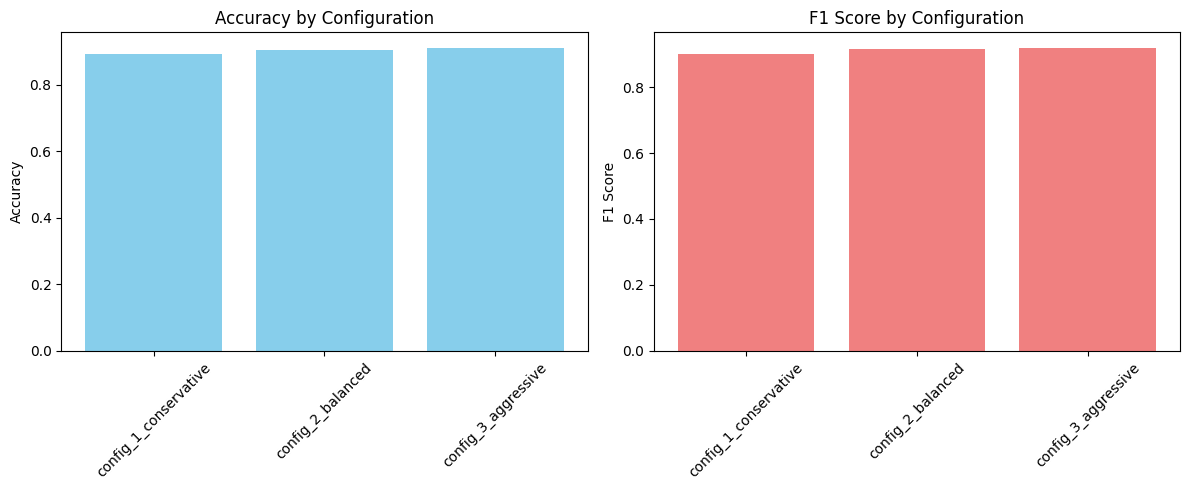

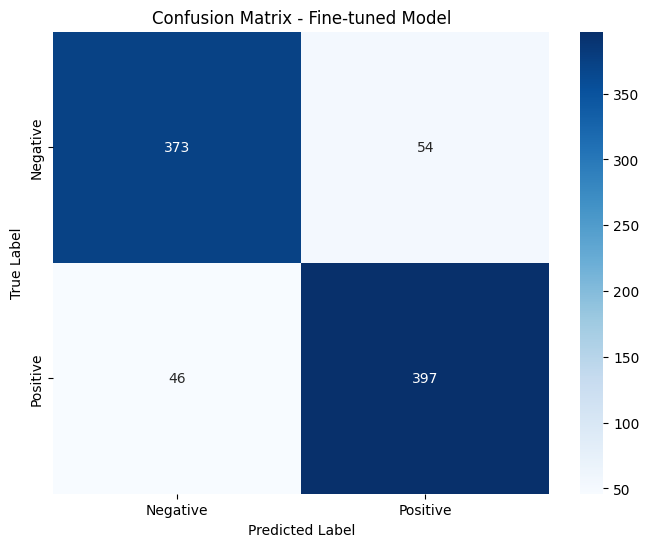

In [ ]:
# Performance comparison chart
configs = [result['config']['name'] for result in training_results]
accuracies = [result['eval_results']['eval_accuracy'] for result in training_results]
f1_scores = [result['eval_results']['eval_f1'] for result in training_results]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(configs, accuracies, color='skyblue')
plt.title('Accuracy by Configuration')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(configs, f1_scores, color='lightcoral')
plt.title('F1 Score by Configuration')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('hyperparameter_comparison.png')
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Fine-tuned Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')